# Setup

In [ ]:
# Basics
from pathlib import Path
from joblib import dump
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
from matplotlib import pyplot as plt, dates
from sklearn.preprocessing import MinMaxScaler

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima

# Neural Netwoks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

In [2]:
# Paths
raw_data_folder = Path.cwd().resolve().parent.joinpath("data", "raw")
processed_data_folder = Path.cwd().resolve().parent.joinpath("data", "processed")
models_folder = Path.cwd().resolve().parent.joinpath("models")

# 1. Loading data

In [3]:
df = pd.read_csv(
    filepath_or_buffer=processed_data_folder.joinpath("10.115.17.226.csv"), 
    index_col=0,
    parse_dates=True
)

This equipment has duplicate measurements on the first two days (very close time and same value) and 2 measurements on the last day. The measurements do not change during the intra-day period.

A resampling technique will be applied to standardize the data in 6-hour periods.

The business rule influences the applicability of this technique (Why this different behavior for this equipment? Is the exact time of measurement relevant? How does the measurement work?) and can be further investigated.

In [4]:
df = df.resample(rule="6h").mean().interpolate()

# 2. Time Series analysis

## Helium level

In [5]:
measure = "HeliumLevel"

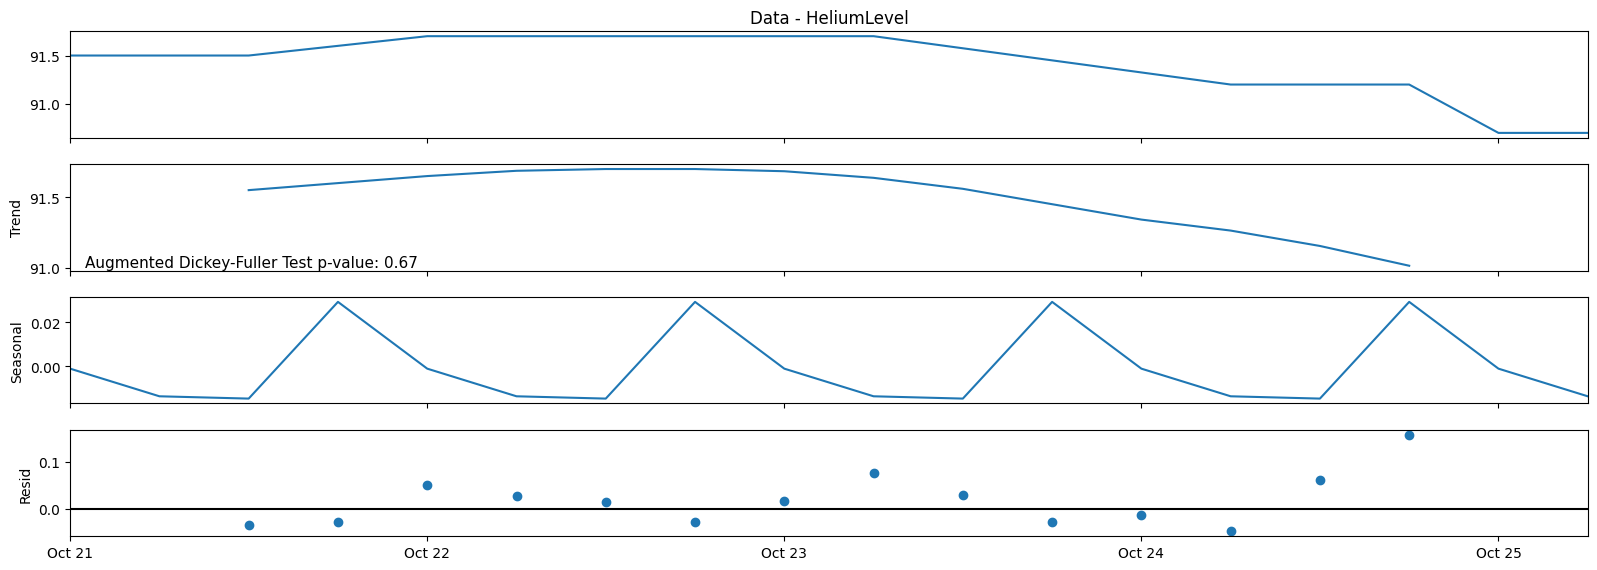

In [6]:
fig_helium = seasonal_decompose(
    df[measure], 
    model="additive",  # From EDA visualization
    period=4 # 6h frequency and 4 periods for a day
).plot()
fig_helium.set_size_inches(18, 6)
fig_helium.axes[0].set_title(f"{df.index.name} - {measure}")
for ax in fig_helium.axes:
    ax.xaxis.set_major_locator(dates.DayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b %d"))
fig_helium.axes[1].text(
        x=0.01, 
        y=0.01, 
        s=f"Augmented Dickey-Fuller Test p-value: {adfuller(df[measure])[1]:.2f}", 
        ha="left", 
        va="bottom",
        fontsize=11,
        transform=fig_helium.axes[1].transAxes
    )
helium_adfuler_pval = adfuller(df[measure])[1]
bore_adfuler_pval = adfuller(df[measure])[1]
plt.show()

## Bore temperature

In [7]:
measure = "BoreTemperature"

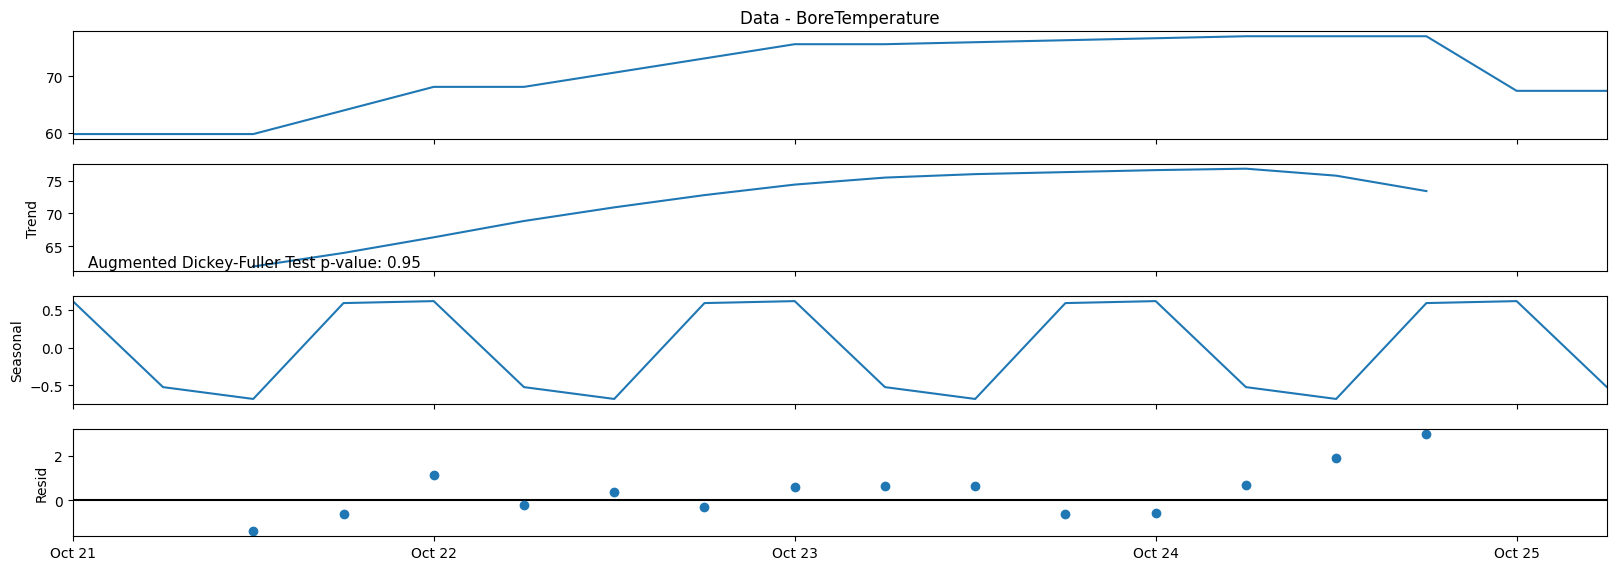

In [8]:
fig_helium = seasonal_decompose(
    df[measure], 
    model="additive",  # From EDA visualization
    period=4 # 6h frequency and 4 periods for a day
).plot()
fig_helium.set_size_inches(18, 6)
fig_helium.axes[0].set_title(f"{df.index.name} - {measure}")
for ax in fig_helium.axes:
    ax.xaxis.set_major_locator(dates.DayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b %d"))
fig_helium.axes[1].text(
        x=0.01, 
        y=0.01, 
        s=f"Augmented Dickey-Fuller Test p-value: {adfuller(df[measure])[1]:.2f}", 
        ha="left", 
        va="bottom",
        fontsize=11,
        transform=fig_helium.axes[1].transAxes
    )
helium_adfuler_pval = adfuller(df[measure])[1]
bore_adfuler_pval = adfuller(df[measure])[1]
plt.show()

# 3. Machine Learning modeling

In [10]:
measures = ["HeliumLevel", "BoreTemperature"]

Division:
- Training: first 4 and a half days.
- Testing: last 24 hours.

Model evaluation metric:
- Lowest RMSE (Root Mean Squared Error).

In [ ]:
# Splitting dataset
df_train = df.iloc[:-4]
df_test = df.iloc[-4:]

# Function to plot the 
def plot_predictions(
    df_train, 
    df_test, 
    model, 
    measures, 
    helium_predictions, 
    helium_metrics,
    bore_predictions, 
    bore_metrics,
):
    """Function to plot the time series train, test and predictions values and print error metrics in the plot"""
    fig_hw, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    fig_hw.tight_layout()
    axes[0].set_title(f"{measures[0]}")
    axes[0].xaxis.label.set_visible(False)
    df_train[measures[0]].plot(legend=True, label="Train", marker=".",ax=axes[0])
    ## Concatenating time series just to keep the lines connected
    pd.concat([df_train[measures[0]].last("6H"), df_test[measures[0]]]).plot(legend=True, label="Test", marker=".", ax=axes[0])
    pd.concat([df_train[measures[0]].last("6H"), helium_predictions]).plot(legend=True, label="Pred", marker=".", ax=axes[0])
    axes[0].text(
        x=0.01, 
        y=0.02, 
        s=f"{model}\nMAPE: {helium_metrics[0]*100:.2f}\nRMSE: {helium_metrics[1]:.2f}", 
        ha="left", 
        va="bottom",
        fontsize=11,
        transform=axes[0].transAxes
    )
    axes[1].set_title(f"{measures[1]}")
    axes[1].xaxis.label.set_visible(False)
    df_train[measures[1]].plot(legend=True, label="Train", marker=".",ax=axes[1])
    ## Concatenating time series just to keep the lines connected
    pd.concat([df_train[measures[1]].last("6H"), df_test[measures[1]]]).plot(legend=True, label="Test", marker=".", ax=axes[1])
    pd.concat([df_train[measures[1]].last("6H"), bore_predictions]).plot(legend=True, label="Pred", marker=".", ax=axes[1])
    axes[1].text(
        x=0.99, 
        y=0.02, 
        s=f"{model}\nMAPE: {bore_metrics[0]*100:.2f}\nRMSE: {bore_metrics[1]:.2f}", 
        ha="right", 
        va="bottom",
        fontsize=11,
        transform=axes[1].transAxes
    )
    plt.show()

## 3.1 Using Holt-Winters

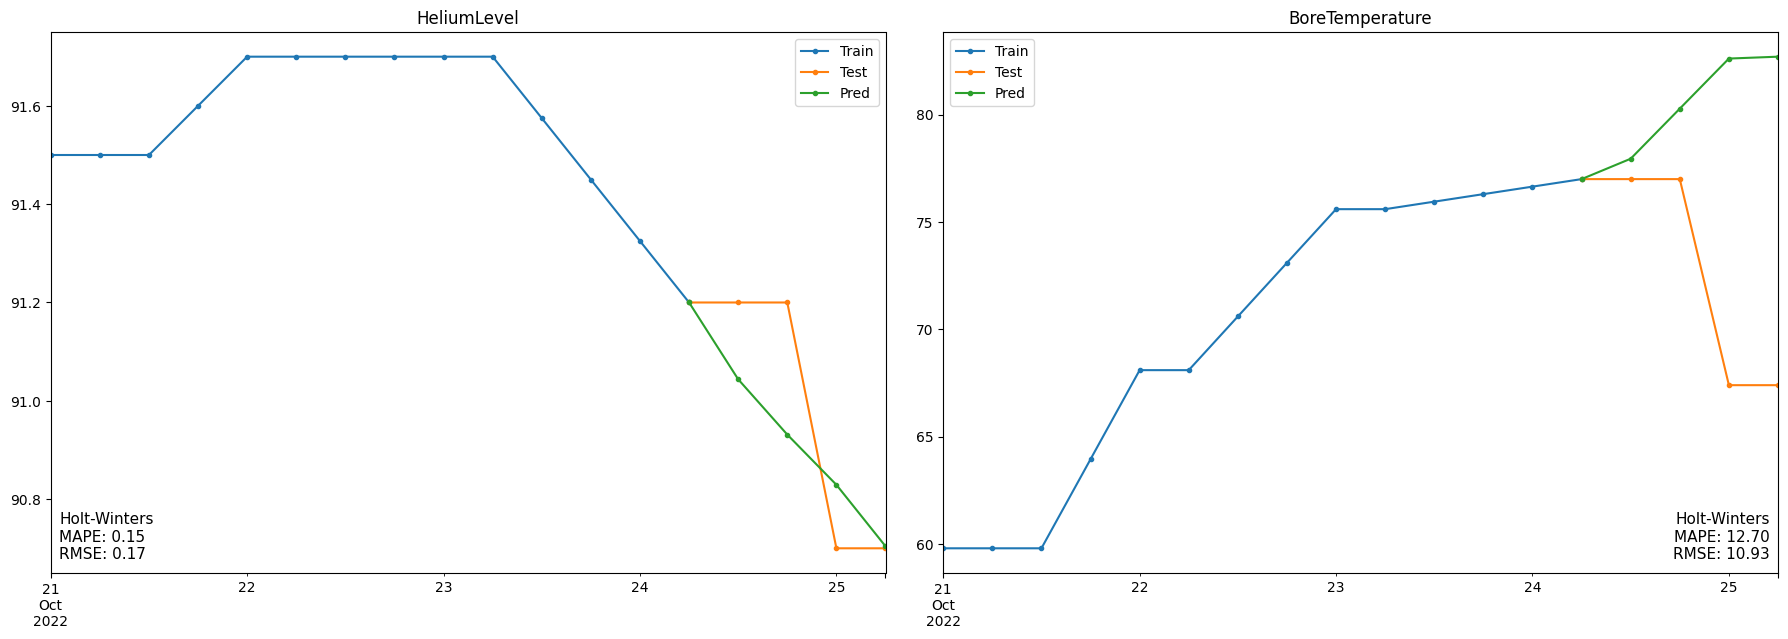

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    helium_hw_model = ExponentialSmoothing(
        endog=(df_train[measures[0]]),
        trend='add',  # From EDA
        seasonal="add",  # From EDA
        seasonal_periods=4  # A day
    ).fit()
    helium_hw_predictions = helium_hw_model.forecast(4)
    helium_hw_metrics = (
        mape(df_test[measures[0]], helium_hw_predictions),  # MAPE
        np.sqrt(mse(df_test[measures[0]], helium_hw_predictions))  # RMSE
    )

    bore_hw_model = ExponentialSmoothing(
        endog=(df_train[measures[1]]),
        trend='add',
        seasonal="add",
        seasonal_periods=4
    ).fit()
    bore_hw_predictions = bore_hw_model.forecast(4)
    bore_hw_metrics = (
        mape(df_test[measures[1]], bore_hw_predictions),
        np.sqrt(mse(df_test[measures[1]], bore_hw_predictions))
    )
    plot_predictions(
        df_train=df_train, 
        df_test=df_test, 
        model="Holt-Winters", 
        measures=measures, 
        helium_predictions=helium_hw_predictions, 
        helium_metrics=helium_hw_metrics,
        bore_predictions=bore_hw_predictions, 
        bore_metrics=bore_hw_metrics,
    )

## 3.2 Using AutoARIMA

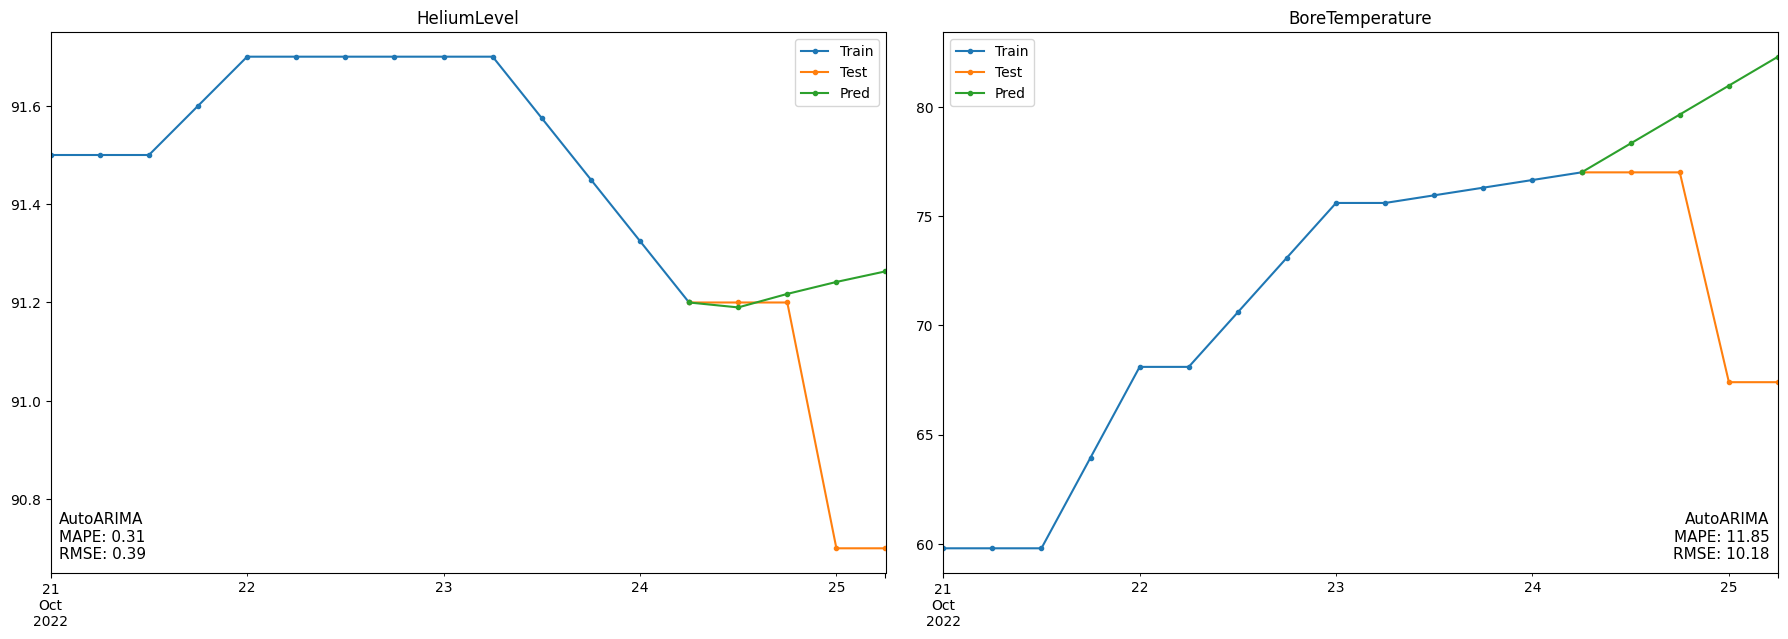

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    helium_arima_predictions = auto_arima(
        y=df_train[measures[0]],
        start_p=1, 
        start_q=1,
        max_p=3, 
        max_q=3,
        max_d=3,
        stepwise=True
    ).fit_predict(y=df_train[measures[0]], n_periods=4)
    helium_arima_metrics = (
        mape(df_test[measures[0]], helium_arima_predictions),
        np.sqrt(mse(df_test[measures[0]], helium_arima_predictions))
    )

    bore_arima_predictions = auto_arima(
        y=df_train[measures[1]],
        start_p=1, 
        start_q=1,
        max_p=3, 
        max_q=3,
        max_d=3,
        stepwise=True
    ).fit_predict(y=df_train[measures[1]], n_periods=4)
    bore_arima_metrics = (
        mape(df_test[measures[1]], bore_arima_predictions),
        np.sqrt(mse(df_test[measures[1]], bore_arima_predictions))
    )

    plot_predictions(
        df_train=df_train, 
        df_test=df_test, 
        model="AutoARIMA", 
        measures=measures, 
        helium_predictions=helium_arima_predictions, 
        helium_metrics=helium_arima_metrics,
        bore_predictions=bore_arima_predictions, 
        bore_metrics=bore_arima_metrics,
    )

## 3.3 Using Recurrent Neural Network

/Users/ewerthon/Library/Caches/pypoetry/virtualenvs/time-series-sensor-kat8u2Pt-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Users/ewerthon/Library/Caches/pypoetry/virtualenvs/time-series-sensor-kat8u2Pt-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


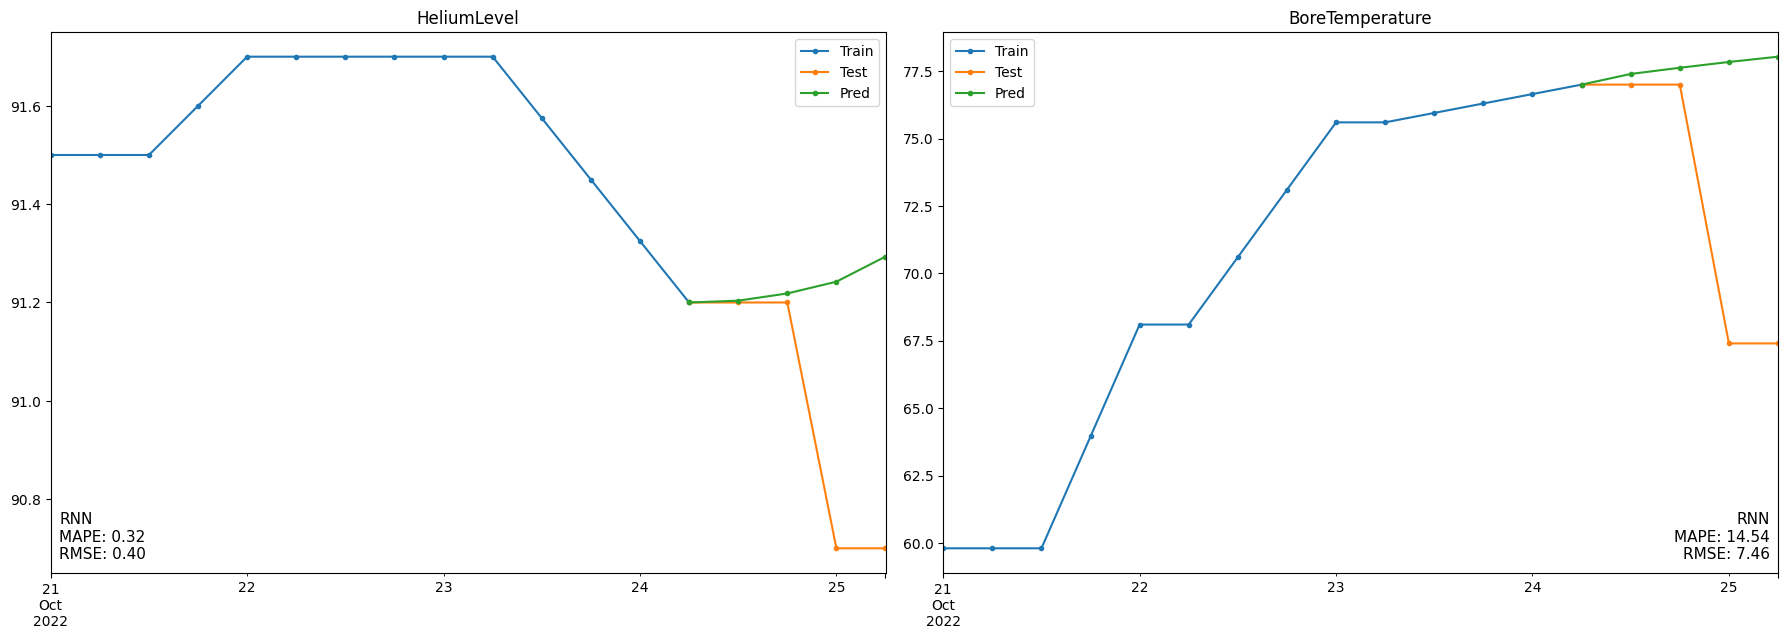

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Univariate with 4 periods/day
    n_input, n_features = 4, 1

    # Helium
    helium_scaler = MinMaxScaler()
    helium_scaler.fit(pd.DataFrame(df_train[measures[0]]))
    df_helium_train_scaled = helium_scaler.transform(pd.DataFrame(df_train[measures[0]]))
    df_helium_test_scaled = helium_scaler.transform(pd.DataFrame(df_test[measures[0]]))

    # Generating Time Series from data
    helium_generator = TimeseriesGenerator(
        data=df_helium_train_scaled, 
        targets=df_helium_train_scaled, 
        length=n_input,
        batch_size=1
    )

    helium_rnn_model = Sequential([
        Input(shape=(n_input, n_features)),
        LSTM(
            units=100,
            activation="relu"
        ),
        Dense(units=1),
    ])
    helium_rnn_model.compile(
        optimizer='adam', 
        loss='mse'
    )
    helium_rnn_model.fit(
        x=helium_generator, 
        epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
    )

    # Getting predictions
    helium_rnn_predictions = list()
    batch = df_helium_train_scaled[-n_input:].reshape((1, n_input, n_features))
    for value_to_predict in range(len(df_helium_test_scaled)):
        prediction = helium_rnn_model.predict(x=batch, verbose=0)[0]
        helium_rnn_predictions.append(prediction)
        batch = np.append(batch[:,1:,:], [[prediction]], axis=1)
    helium_rnn_predictions = helium_scaler.inverse_transform(helium_rnn_predictions)
    helium_rnn_predictions = pd.Series(helium_rnn_predictions.reshape(-1))
    helium_rnn_predictions.index = df_test.index
    helium_rnn_metrics = (
        mape(df_test[measures[0]], helium_rnn_predictions),
        np.sqrt(mse(df_test[measures[0]], helium_rnn_predictions))
    )

    # Bore
    bore_scaler = MinMaxScaler()
    bore_scaler.fit(pd.DataFrame(df_train[measures[1]]))
    df_bore_train_scaled = bore_scaler.transform(pd.DataFrame(df_train[measures[1]]))
    df_bore_test_scaled = bore_scaler.transform(pd.DataFrame(df_test[measures[1]]))


    bore_generator = TimeseriesGenerator(
        data=df_bore_train_scaled, 
        targets=df_bore_train_scaled, 
        length=n_input,
        batch_size=1
    )

    bore_rnn_model = Sequential([
        Input(shape=(n_input, n_features)),
        LSTM(
            units=100,
            activation="relu"
        ),
        Dense(units=1),
    ])
    bore_rnn_model.compile(
        optimizer='adam', 
        loss='mse'
    )
    bore_rnn_model.fit(
        x=bore_generator, 
        epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
    )
    bore_rnn_predictions = list()
    batch = df_bore_train_scaled[-n_input:].reshape((1, n_input, n_features))
    for value_to_predict in range(len(df_bore_test_scaled)):
        prediction = bore_rnn_model.predict(x=batch, verbose=0)[0]
        bore_rnn_predictions.append(prediction)
        batch = np.append(batch[:,1:,:], [[prediction]], axis=1)
    bore_rnn_predictions = bore_scaler.inverse_transform(bore_rnn_predictions)
    bore_rnn_predictions = pd.Series(bore_rnn_predictions.reshape(-1))
    bore_rnn_predictions.index = df_test.index
    bore_rnn_metrics = (
        mape(df_test[measures[0]], bore_rnn_predictions),
        np.sqrt(mse(df_test[measures[1]], bore_rnn_predictions))
    )

    plot_predictions(
        df_train=df_train, 
        df_test=df_test, 
        model="RNN", 
        measures=measures, 
        helium_predictions=helium_rnn_predictions, 
        helium_metrics=helium_rnn_metrics,
        bore_predictions=bore_rnn_predictions, 
        bore_metrics=bore_rnn_metrics,
    )

# 4. Saving Model

- Best performing model for Helium: Holt-Winters
- Best performing model for Bore: RNN

Saving both models.

In [27]:
# Helium HW
helium_hw_model = ExponentialSmoothing(
    endog=(df[measures[0]]),
    trend='add',
    seasonal="add",
    seasonal_periods=4
).fit()
dump(helium_hw_model, models_folder/"10.115.17.226_helium_model.joblib")

# Bore RNN
bore_scaler = MinMaxScaler()
bore_scaler.fit(pd.DataFrame(df[measures[1]]))
df_bore_scaled = bore_scaler.transform(pd.DataFrame(df[measures[1]]))
bore_generator = TimeseriesGenerator(
    data=df_bore_scaled, 
    targets=df_bore_scaled, 
    length=n_input,
    batch_size=1
)
helium_rnn_model.fit(
    x=bore_generator, 
    epochs=100,
    verbose=0,
    callbacks=[EarlyStopping(monitor="loss", min_delta=0.001, patience=10)]
)
bore_rnn_model.save(models_folder/"10.115.17.226_bore_model.keras")

/Users/ewerthon/Library/Caches/pypoetry/virtualenvs/time-series-sensor-kat8u2Pt-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
